Creates dataset-1: https://www.notion.so/Vesuvius-Challenge-5a018b4dede84ac09ebca3aa7d707fdb?pvs=4#bd95954ee1bb40418eafb36b29ea7203

**Train data:** 

- **upper 80% from all of the images**

**Test data:**

- **lower 20% from all of the images.**

Note: you need to do the same to images and the labels.

Also, apply augmentations (to both images and labels, but only to the train data):
- Take random crops of size between 512^2 and 1024^2. 
- Take random crop simultaneously on the image, mask and the label.
- Discard the crop if if there is less than 35% of mask pixels in the crop.

Apply the following augmentations to the (768, 768, 64) images:
- RandomHorizontalFlip
- RandomVerticalFlip
- RandomNoise
- Multiply whole image by random 0.9-1.1 number


The idea is that at the end you have the following folder structure:
```
train/
    img/
        1.png
        2.png
        ...
    label/
        1.png
        2.png
        ...
test/
    img/
        1.png
        2.png
        ...
    label/
        1.png
        2.png
        ...
```

If you take subset of 48x48x64 images, then you will have about ~(6000/48)=125^2= 15625 images. If you augment each subimage 100 times, that's about 280Gb.

In [1]:
import numpy as np # linear algebra
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import albumentations as A


# Augmentations

In [2]:

mask = np.array(Image.open('../../kaggle-data/vesuvius-challenge-ink-detection/train/1/mask.png'))
ink_labels = np.array(Image.open('../../kaggle-data/vesuvius-challenge-ink-detection/train/1/inklabels.png'))


mask.shape, mask.dtype, ink_labels.shape, ink_labels.dtype

((8181, 6330), dtype('uint8'), (8181, 6330), dtype('uint8'))

In [3]:
def load_volume(surface_volume_path):
    img = []
    for i in tqdm(range(64)):
        x = np.array(Image.open(os.path.join(surface_volume_path, f'{i:02d}.tif')))
        img.append(x)
    return np.array(img)

In [4]:
volume = load_volume('../../kaggle-data/vesuvius-challenge-ink-detection/train/1/surface_volume')
# permute: (z, x, y) -> (x, y, z)
volume = np.transpose(volume, (1, 2, 0))
volume.shape

100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


(8181, 6330, 64)

In [5]:
x1 = 2500
x2 = x1 + 768
y1 = 2500
y2 = y1 + 768

# Take subset of the image to see how the augmentations work
volume_sample = volume[x1:x2, y1:y2, :]
mask_sample = mask[x1:x2, y1:y2]
ink_labels_sample = ink_labels[x1:x2, y1:y2]

In [6]:
volume_sample.shape, mask_sample.shape, ink_labels_sample.shape

((768, 768, 64), (768, 768), (768, 768))

In [7]:
np.max(volume), np.max(mask), np.max(ink_labels)

(65535, 1, 1)

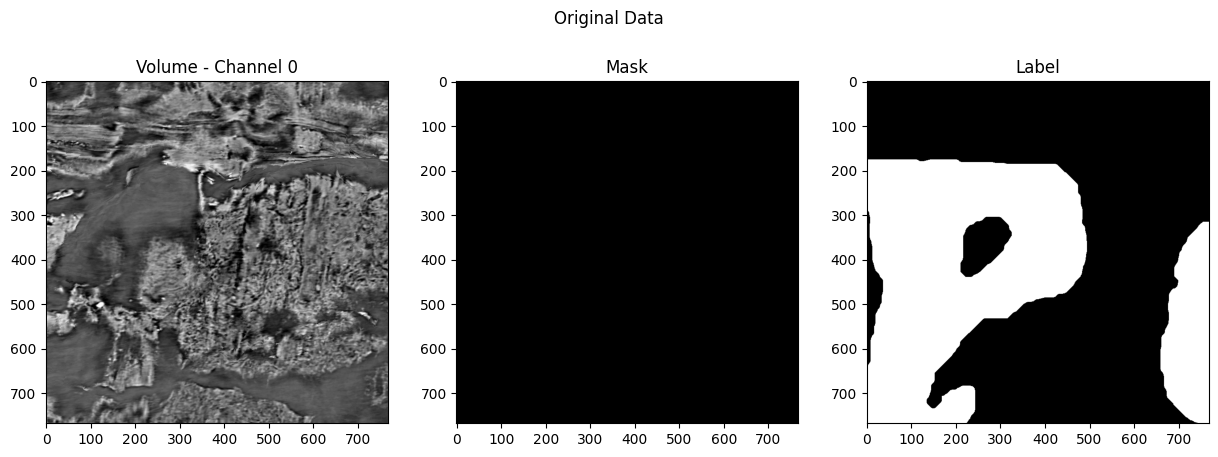

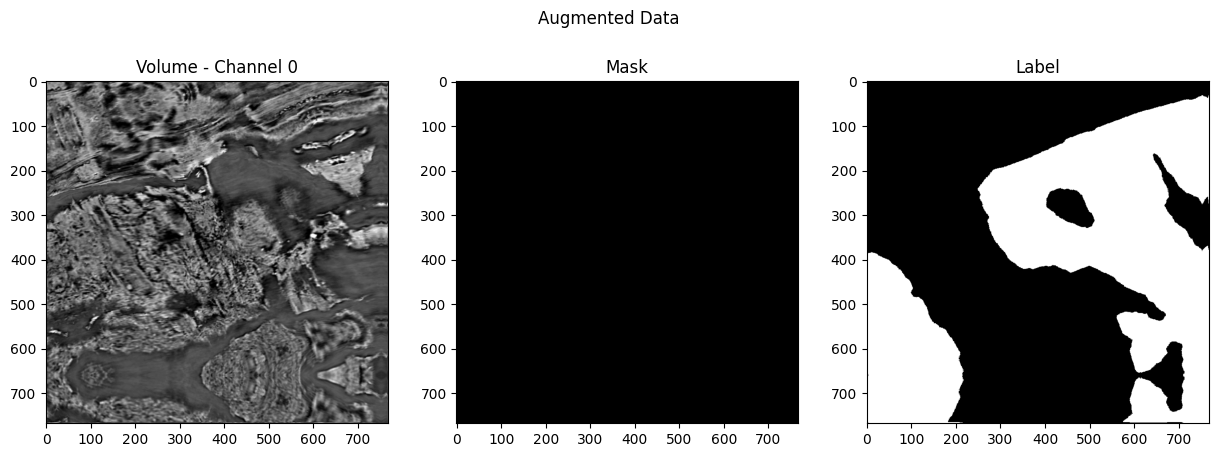

In [9]:

# Define the augmentation pipeline for single-channel mask and label
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=45, p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
#     A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
#     A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
# ], additional_targets={'label': 'mask'})

augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=64, max_height=64, 
                        mask_fill_value=0, p=0.5),
    
], additional_targets={'label': 'mask'})


def apply_augmentation(image, mask, label):
    augmented = augmentation(image=image, mask=mask, label=label)
    return augmented['image'], augmented['mask'], augmented['label']

# Apply the augmentation
aug_volume, aug_mask, aug_label = apply_augmentation(volume_sample, mask_sample, ink_labels_sample)

# Visualize the original and augmented data
def visualize(volume, mask, label, title, indx=0):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(volume[:, :, indx], cmap='gray')
    ax1.set_title('Volume - Channel 0')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax3.imshow(label, cmap='gray')
    ax3.set_title('Label')
    fig.suptitle(title)
    plt.show()

visualize(volume_sample, mask_sample, ink_labels_sample, "Original Data")
visualize(aug_volume, aug_mask, aug_label, "Augmented Data")

In [9]:
def random_crop(volume, mask, label):
    # Note: image_data_format is 'channel_last'
    # take random number between 512 and 1024
    crop_size = np.random.randint(512, 1024)
    height, width = volume.shape[:-1]
    dx = crop_size
    dy = crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    volume_crop = volume[y:(y+dy), x:(x+dx), :]
    mask_crop = mask[y:(y+dy), x:(x+dx)]
    label_crop = label[y:(y+dy), x:(x+dx)]
    return volume_crop, mask_crop, label_crop
v, m, l = random_crop(volume, mask, ink_labels)
v.shape, m.shape, l.shape

((684, 684, 64), (684, 684), (684, 684))

In [10]:
# resize the volume to 768x768 using albumentations
def resize_to_768(volume, mask, label):
    resize = A.Compose([
        A.Resize(height=768, width=768, p=1)
    ], additional_targets={'label': 'mask'})
    # Apply the resize
    augmented = resize(image=volume_sample, mask=mask_sample, label=ink_labels_sample)
    aug_volume, aug_mask, aug_label = augmented['image'], augmented['mask'], augmented['label']
    return aug_volume, aug_mask, aug_label
v, m, l = resize_to_768(v, m, l)
v.shape, m.shape, l.shape

((768, 768, 64), (768, 768), (768, 768))

In [11]:
def augment(volume, mask, label):
    # random crop
    v, m, l = random_crop(volume, mask, label)
    # apply augmentation    
    v, m, l = apply_augmentation(v, m, l)
    # resize to 768x768
    v, m, l = resize_to_768(v, m, l)
    return v, m, l

%timeit augment(volume, mask, ink_labels) # 6 seconds per loop!
# v, m, l = augment(v, m, l)
# v.shape, m.shape, l.shape

The slowest run took 14.64 times longer than the fastest. This could mean that an intermediate result is being cached.
907 ms ± 741 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Splitting 1

In [12]:
root_dir = "../kaggle-data/vesuvius-challenge-ink-detection/train/1"

In [13]:
def process_img(img_path):
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint16)
    n_rows = img.shape[0]
    n_train = int(n_rows * 0.75)
    train_img = img[:n_train]
    n_train = int(n_rows * 0.8) # You ignore 5% of the data between train and test, so that you don't have data leak. 
    test_img = img[n_train:]
    return train_img, test_img

In [14]:
train_img, test_img = process_img(f"{root_dir}/surface_volume/00.tif")
train_img.shape, test_img.shape

FileNotFoundError: [Errno 2] No such file or directory: '../kaggle-data/vesuvius-challenge-ink-detection/train/1/surface_volume/00.tif'

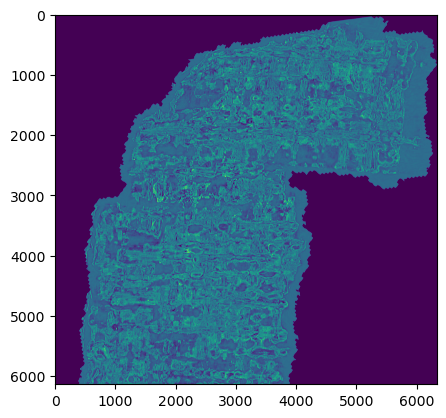

In [ ]:
plt.imshow(train_img)

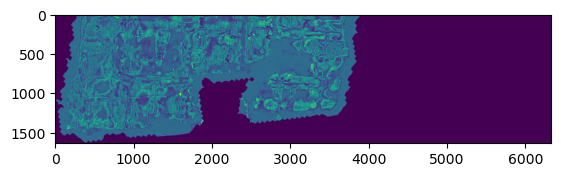

In [ ]:
plt.imshow(test_img)

In [ ]:
for i in tqdm(range(65)):
    fname = f"{root_dir}/surface_volume/{i:02d}.tif"
    train_img, test_img = process_img(fname)

100%|██████████| 65/65 [00:16<00:00,  4.01it/s]
